In [1]:
import sys                       
sys.path.append('.')
from robot_aoa import *
from scipy.stats import expon, norm, uniform
#import filterp
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import sympy as sp

In [2]:
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    # observasion: data from the sensors
    # self.{nu,omega}: movement
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        #x, y, t = self.estimator.pose #以下追加
        #s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        #elems.append(ax.text(x, y+0.1, s, fontsize=8))

In [3]:
def line_cross_point(P0, P1, Q0, Q1):
    x0, y0 = P0; x1, y1 = P1
    x2, y2 = Q0; x3, y3 = Q1
    a0 = x1 - x0; b0 = y1 - y0
    a2 = x3 - x2; b2 = y3 - y2

    d = a0*b2 - a2*b0
    if d == 0:
        # two lines are parallel
        return None

    # s = sn/d
    sn = b2 * (x2-x0) - a2 * (y2-y0)
    # t = tn/d
    #tn = b0 * (x2-x0) - a0 * (y2-y0)
    return x0 + a0*sn/d, y0 + b0*sn/d

#print(line_cross_point((0, 0), (0, 3), (1, 10), (3, -1)))
# => (0.0, 15.5)

In [4]:
# Estimator
class EstimatorKalmanFilter:
    def __init__(self, envmap, dt, init_pose):
        
        x = np.array([init_pose[0], 0, init_pose[1], 0])
        P = np.diag([100., 100., 100., 100.])
        R = np.array([[1., 0.],
                      [0., 1.]])
        Q = np.array([[0.,    0.001, 0., 0.],
                      [0.001, 0.001, 0., 0.],
                      [0.,    0.,    0., 0.],
                      [0.,    0.,    0., 0.]])

        kf = KalmanFilter(dim_x=4, dim_z=2)
        kf.x = x
        kf.F = np.array([[1., dt, 0., 0.],
                         [0., 1., 0., 0.],
                         [0., 0., 1., 0.],
                         [0., 0., 0., 1.]])  # state transition matrix    
        kf.H = np.array([[1., 0., 0, 0.],
                         [0., 0., 1, 0.]])
        kf.R *= R                     # measurement uncertainty
        if np.isscalar(P):
            kf.P *= P                 # covariance matrix 
        else:
            kf.P[:] = P               # [:] makes deep copy
        if np.isscalar(Q):
            kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=Q)
        else:
            kf.Q[:] = Q
            
        self.pose = kf.x
        self.kf = kf  
        self.estimated_poses = [kf.x]
        self.map = envmap
        
    #
    # Agent から呼ばれる
    # observasion はノイズを含むセンサからの観測値
    #    (z, ant.pos, ant.id) = robot.AoA.data()
    #         # 以下の理想的な値にノイズを載せたものが上記観測値となる
    #         z = IdealAoA.observation_function()
    #         # 観測値zの内訳は以下の通りで、0 は位置情報でありセンサデータとして未使用
    #         np.array([0, theta]).T
    #
    def observation_update(self, observation):  #追加
        # observation[]: [(0, 角度), アンテナ位置, 観測ID]
        #    z = d[0][1] # d[0] = (0, theta)
        #    ant_pos = d[1]
        #    obs_id = d[2]
        ant1 =observation[0] 
        ant2 =observation[1] 
        z1 = ant1[0][1]
        z2 = ant2[0][1]
        a1 = math.tan(z1)
        a2 = math.tan(z2)
        p1 = ant1[1]
        p2 = ant2[1]
        x1 = 10
        x2 = 0
        c = line_cross_point((p1[0], p1[1]), (x1, a1*x1+a1*-p1[0]+p1[1]),
                             (p2[0], p2[1]), (x2, a2*x2+a2*-p2[0]+p2[1]))   
        self.kf.update([c[0], c[1]])
        
    def motion_update(self, nu, omega, time): #追加
        if abs(omega) < 1e-5: omega = 1e-5 #値が0になるとゼロ割りになって計算ができないのでわずかに値を持たせる

        self.kf.predict()
        
        #  kf.x = [x, y, theta]
        pose = np.array([self.kf.x[0], self.kf.x[2], self.pose[2]]).T
        self.pose = IdealRobot.state_transition(nu, omega, time, pose)

        
    def draw(self, ax, elems):
        x = self.kf.x
        #elems.append(ax.text(0.5, 9.0, "x:" + str(x[0]), fontsize=10))
        #elems.append(ax.text(0.5, 8.5, "y:" + str(x[2]), fontsize=10))
        #elems += ax.plot(x[0], x[2], color="blue", alpha=0.5, linewidth=0.5, marker='o')
        
        self.estimated_poses.append(x)
        xs = [_x[0] for _x in self.estimated_poses]
        ys = [_x[2] for _x in self.estimated_poses]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5, linewidth=0.5)
        c = patches.Circle(xy=(x[0], x[2]), radius=0.1, fill=True, alpha=0.5, color="blue")
        elems.append(ax.add_patch(c))

<IPython.core.display.Javascript object>


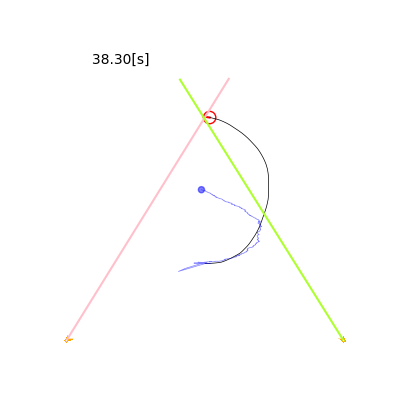

In [5]:
if __name__ == '__main__': 
    dt = 0.1
    #world = World(0.5, time_interval, debug=True)  
    world = World(60, dt)
    
    m = Map()                                  
    m.append_antenna(Antenna(0.5, 0.5))
    m.append_antenna(Antenna(9.5, 0.5))
    world.append(m)        
    
    #pose, nu, omega = np.array([2, 4, 0]), 0.2, 0.0
    pose, nu, omega = np.array([5, 3, 0]), 0.2, 5.0/180*math.pi
    
    e = EstimatorKalmanFilter(m, dt, pose)
    a = EstimationAgent(dt, nu, omega, e)
    r = Robot(pose, sensor=AoA(m), agent=a, color="red") 
    
    world.append(r)
                 
    ### アニメーション実行 ###
    world.draw()